In [305]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

%matplotlib inline
import matplotlib.pyplot as plt

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer

from PIL import Image
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import matplotlib.cm as cm
from matplotlib.pyplot import subplots

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib

import yaml

zsh:1: command not found: nvcc
torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


In [306]:
ROOT_DIR = "../../data/bias_triangles"

MODEL_DATA_DIR = os.path.join(ROOT_DIR, "processed")

MODEL_TRAIN_DATA_DIR = os.path.join(MODEL_DATA_DIR,"train")
MODEL_VAL_DATA_DIR = os.path.join(MODEL_DATA_DIR,"val")
MODEL_TEST_DATA_DIR = os.path.join(MODEL_DATA_DIR,"test")

config_path = "./config.yaml"

model_name = 'psb'

with open(config_path, 'r') as config_yaml:
            model_yaml = yaml.load(config_yaml, Loader=yaml.FullLoader)
            model_config = model_yaml[model_name]
            model_info = model_config['info']
            model_hyperparams = model_config['hyperparameters']

            model_device = model_yaml['device']


In [307]:
def get_bias_triangle_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_bias_triangle_11Apr2024_12h19m_json.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        record["file_name"] = os.path.join(img_dir, v["filename"])
        record["image_id"] = idx

        annos = v["regions"]

        objs = []

        if type(annos) == list: # custom JSONs are in list format need to make them the same
             annos = dict(enumerate(annos))

        for _, anno in annos.items():

            regions = anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]

            # if len(px) <= 10 or len(py) <= 10:
            #         # print("Ignoring polygon from ", v["filename"], "because a polygon was too small for detectron2.")
            #         continue
            
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]


            category_dict = {"unblocked": 0, "blocked": 1}
            category_id = category_dict[regions["label"]]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": category_id,
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

../../data/bias_triangles/processed/train/train_12_blocked.jpg
../../data/bias_triangles/processed/train/train_581_0_sim_unblocked.jpg
../../data/bias_triangles/processed/train/train_532_1_sim_blocked.jpg


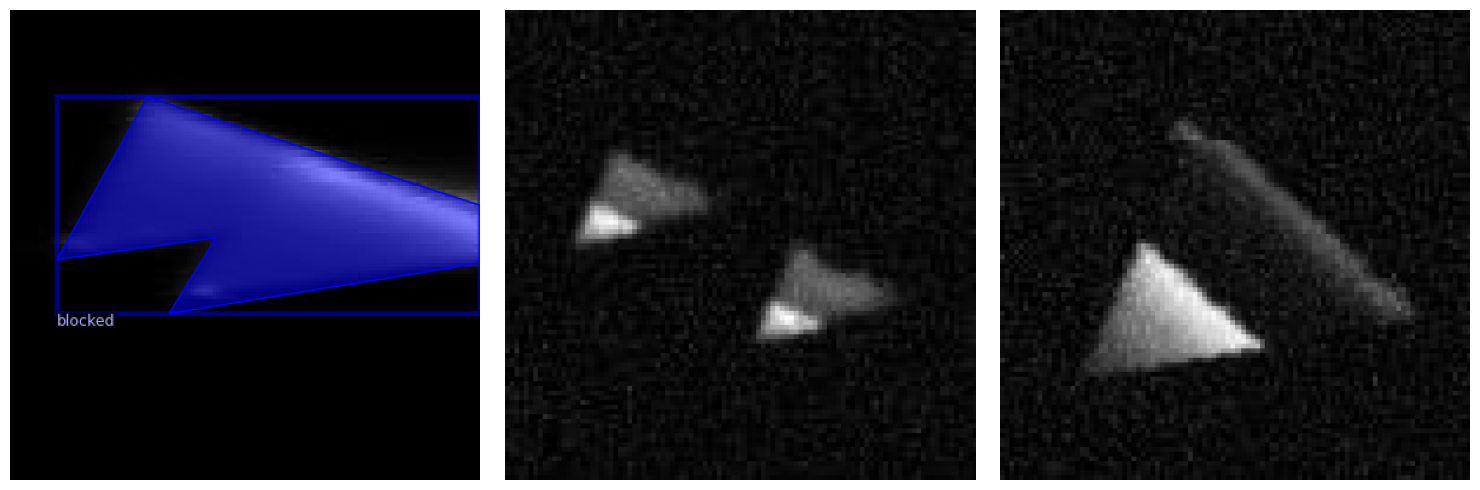

In [341]:
DatasetCatalog.clear()
MetadataCatalog.clear()

for d in ["train", "val"]:
    DatasetCatalog.register("csd_" + d, lambda d=d: get_bias_triangle_dicts(os.path.join(MODEL_DATA_DIR,d)))
    MetadataCatalog.get("csd_" + d).set(thing_classes=list(model_info['class_dict'].keys()))

csd_train_metadata = MetadataCatalog.get("csd_train")
csd_val_metadata = MetadataCatalog.get("csd_val")

# WHICH TO CHECK?
dataset_to_check = "train"

dataset_dir = MODEL_TRAIN_DATA_DIR if dataset_to_check == "train" else MODEL_VAL_DATA_DIR

dataset_dicts = get_bias_triangle_dicts(dataset_dir)

num_of_display_images = 3

num_cols = min(3, num_of_display_images)  # Maximum of 3 columns
num_rows = int(np.ceil(num_of_display_images / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, d in enumerate(random.sample(dataset_dicts, num_of_display_images)):
    print(d['file_name'])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=csd_train_metadata, scale=3)
    out = visualizer.draw_dataset_dict(d)
    
    if num_rows > 1:
        ax = axs[i // num_cols, i % num_cols]
    else: 
        ax = axs[i % num_cols]
    ax.imshow(out.get_image()[:, :, ::-1])
    ax.axis("off")

plt.tight_layout()
plt.show()



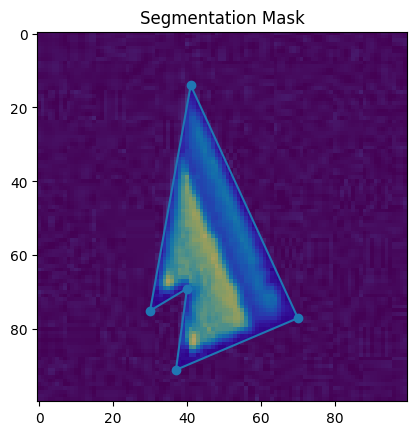

In [285]:
filename = "train_2_1_sim_blocked.jpg"
# filename = "train_1_blocked.jpg"
# filename = "train_3_unblocked.jpg"
json_file = os.path.join(MODEL_TRAIN_DATA_DIR, filename)
img = cv2.imread(json_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# xs = [64,24,51,39,156]
# ys=[38,124,116,140,110]
# xs = [21,1,99]
# ys = [3,60,46]
xs = [41,30,40,37,70]
ys = [14,75,69,91,77]
# xs = [38,13,48,34,119]
# ys = [19,74,64,91,72]
plt.imshow(img)
plt.fill(xs + [xs[0]], ys + [ys[0]], 'b-', alpha=0.3)  # Connect the last point to the first to close the polygon
plt.plot(xs + [xs[0]] ,ys + [ys[0]])
plt.scatter(xs,ys)
plt.title("Segmentation Mask")
plt.show()

